In [15]:
COMPARISONS = ['Lesion_Double_deep_tMPPCA_5D', 'Lesion_double_Ynet', 'Lesion_double_Ynet_fT', 'Lesion_Double_GT']

#COMPARISONS = ['Tumor_1_tMPPCA_5D', 'Tumor_1_deep_tMPPCA_5D','Tumor_1_Part_1_deep_tMPPCA_5D_Ynet', 'Tumor_1_noisy']

#COMPARISONS = ['Tumor_2_tMPPCA_5D', 'Tumor_2_deep_tMPPCA_5D','Tumor_2_noisy']

#COMPARISONS = ['P08_noisy', 'P08_deep_tMPPCA_5D', 'P08_tMPPCA_5D'] 

quality_clip = False # show voxels that meet LC Model quality criteria
outlier_clip = False
clip_pct = 2.0 # entfernt oberste 2% der fehlerpixl um außreißer zu vermeiden

z= 12 #9

# Available methods:
# - P08_noDenoising
# - P08_LR8
# - P08_unet_JInvariant
# - P08_zfT

# - P08_simulated_GT   -- that is ground truth
# - P08_simulated_noisy
# - P08_simulated_LR8
# - P08_simulated_unet_JInvariant

# - Sim_GT_lesion
# - Sim_lesion_deep
# - Sim_lesion_LR8
# - Sim_lesion_noisy

# Note I fitted many more methods, the result of which are in my home directory: /ceph/mri.meduniwien.ac.at/departments/radiology/mrsbrain/home/hfischer

## Fit Rate Laktat

/tmp/ipykernel_2023278/3858910196.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", max(n_methods, 1))


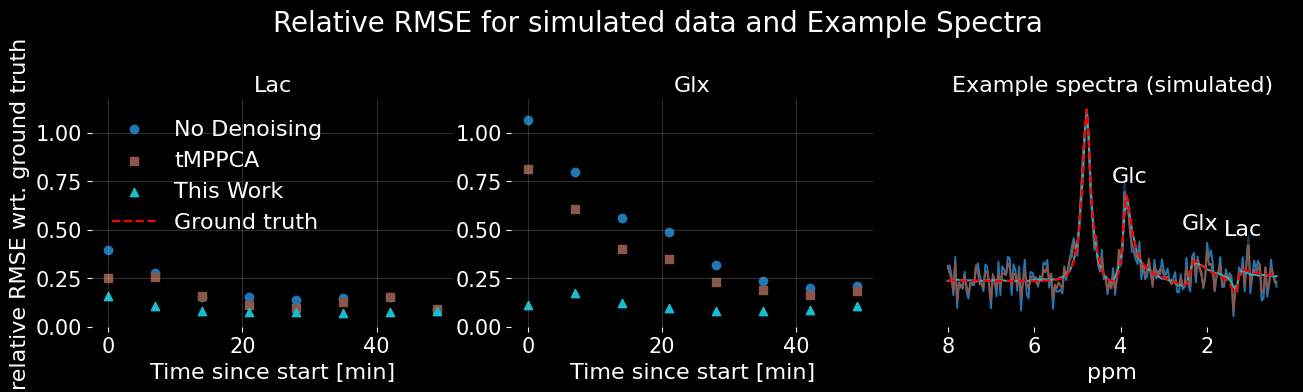

In [3]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

FONTSIZE = 16

def load_example_spectrum(
    base_dir: str,
    rep: int,
    xyz: tuple[int, int, int],
    filename: str = "SpecMap_LCMInput.nii.gz",
) -> np.ndarray:
    """Lädt 1D-Spektrum aus NIfTI (4D: X,Y,Z,S)."""
    spec_path = os.path.join(base_dir, "maps", str(rep), "SpecMap", filename)
    if not os.path.isfile(spec_path):
        raise FileNotFoundError(f"Spektrum nicht gefunden: {spec_path}")
    img = nib.load(spec_path)
    data = img.get_fdata()
    if data.ndim != 4:
        raise ValueError(f"Erwarte 4D (X,Y,Z,S), gefunden: {data.shape}")
    x, y, z = xyz
    return np.asarray(data[x, y, z, :], dtype=np.float64).ravel()


def rrmse_vs_ref(
    metabolite: str,
    methods: List[str],
    *,
    z: int,
    data_dir: str = "MetabMaps",
    quality_clip: bool = False,
    outlier_clip: bool = False,
    return_mask_counts: bool = False,
) -> Dict[str, np.ndarray]:
    """Berechnet rRMSE(t) gegen Referenz (methods[-1])"""
    suffix = "OutlierClip" if outlier_clip else ("QualityClip" if quality_clip else "Orig")
    amps = {}
    for m in methods:
        f = os.path.join(data_dir, m, f"{metabolite}_amp_{m}_{suffix}.npy")
        if not os.path.isfile(f):
            raise FileNotFoundError(f"AMP fehlt: {f}")
        a = np.load(f)
        if a.ndim != 4:
            raise ValueError(f"Unerwartete Shape in {f}: {a.shape}")
        amps[m] = a[z, ...]

    ref = amps[methods[-1]]
    T = ref.shape[-1]
    results = {m: np.zeros(T) for m in methods[:-1]}
    Nmask = np.zeros(T, dtype=int)

    for t in range(T):
        ref_t = ref[..., t]
        mask_t = np.isfinite(ref_t) & (ref_t != 0)
        Nmask[t] = int(mask_t.sum())
        if Nmask[t] == 0:
            continue
        span = np.nanmax(ref_t[mask_t]) - np.nanmin(ref_t[mask_t])
        if span <= 0:
            continue
        for m in methods[:-1]:
            a_t = amps[m][..., t]
            vmask = mask_t & np.isfinite(a_t)
            if vmask.sum() == 0:
                results[m][t] = np.nan
            else:
                diff = a_t[vmask] - ref_t[vmask]
                rmse = np.sqrt(np.mean(diff**2))
                results[m][t] = rmse / span

    if return_mask_counts:
        results["Nmask"] = Nmask
    return results


def plot_rrmse_vs_ref_with_spectra(
    metabolites: List[str],
    methods: List[str],
    *,
    z: int,
    data_dir: str = "MetabMaps",
    quality_clip: bool = False,
    outlier_clip: bool = False,
    minutes_per_rep: float = 5.0,
    labels: List[str] | None = None,
    ymax: float | None = None,
    title: str = "Relative RMSE (CRLB/AMP) and Example Spectra",
    savepath: str | None = None,
    # Spektrum-Panel
    base_dir_root: str = "MetabMaps",
    spec_rep: int = 10,
    spec_xyz: tuple[int, int, int] = (12, 14, 11),
    spec_label: str | None = None,
    spec_ppm: np.ndarray | None = None,
    peak_labels: dict[str, float] | None = None,
    gt_method: str | None = None,
    spec_filename: str = "SpecMap_LCMInput.nii.gz",
):
    """rRMSE (Scatter) + Beispiel-Spektren (mit GT gestrichelt in rot)"""
    n_methods = len(methods) - 1
    cmap = plt.cm.get_cmap("tab10", max(n_methods, 1))
    colors = [cmap(i) for i in range(n_methods)]
    markers = ["o", "s", "^", "D", "v", "P", "X"]

    ref_key = methods[-1]
    gt_key = gt_method or ref_key

    if labels is None:
        plot_labels = methods[:-1]
    else:
        plot_labels = labels[: len(methods) - 1]

    all_rrmse = {}
    for metab in metabolites:
        all_rrmse[metab] = rrmse_vs_ref(metab, methods, z=z, data_dir=data_dir)

    T = next(iter(all_rrmse[metabolites[0]].values())).shape[0]
    time_min = np.arange(0, T) * minutes_per_rep

    # --- globale y-Skala bestimmen ---
    all_vals = np.concatenate([v for metab in metabolites for v in all_rrmse[metab].values()])
    global_ymax = ymax or np.nanmax(all_vals) * 1.1

    # --- Figure ---
    n_panels = len(metabolites) + 1
    fig, axes = plt.subplots(1, n_panels, figsize=(13, 3.8), sharey=False)
    fig.patch.set_facecolor("black")
    for ax in axes:
        ax.set_facecolor("black")

    # --- Scatter-Panels ---
    for j, metab in enumerate(metabolites):
        ax = axes[j]
        for idx, (m, lab) in enumerate(zip(methods[:-1], plot_labels)):
            ax.scatter(
                time_min,
                all_rrmse[metab][m],
                s=36,
                marker=markers[idx % len(markers)],
                color=colors[idx % len(colors)],
                label=lab,
            )
        ax.set_ylim(0, global_ymax)
        ax.set_title(metab, fontsize=16, color="white")
        ax.set_xlabel("Time since start [min]", fontsize=FONTSIZE, color="white")
        if j == 0:
            ax.set_ylabel("relative RMSE wrt. ground truth", fontsize=FONTSIZE, color="white")
        ax.grid(True, alpha=0.25)
        ax.tick_params(colors="white", labelsize=15)
        for spine in ax.spines.values():
            spine.set_visible(False)

    # --- gemeinsame Legende links ---
    handles, labels_ = axes[0].get_legend_handles_labels()
    gt_line = plt.Line2D([], [], color="red", linestyle="--", lw=1.6, label="Ground truth")
    handles.append(gt_line)
    labels_.append("Ground truth")
    axes[0].legend(handles, labels_, frameon=False, loc="upper left", fontsize=FONTSIZE, labelcolor="white")

    # --- Spektrum-Panel ---
    ax_spec = axes[-1]
    specs = []
    for idx, m in enumerate(methods[:-1]):
        spec = load_example_spectrum(os.path.join(base_dir_root, m), spec_rep, spec_xyz, spec_filename)
        spec /= np.nanmax(np.abs(spec)) or 1
        x_axis = spec_ppm if spec_ppm is not None else np.arange(spec.size)
        ax_spec.plot(x_axis, spec, lw=1.4, color=colors[idx % len(colors)])
        specs.append(spec)

    gt_spec = load_example_spectrum(os.path.join(base_dir_root, gt_key), spec_rep, spec_xyz, spec_filename)
    gt_spec /= np.nanmax(np.abs(gt_spec)) or 1
    x_axis = spec_ppm if spec_ppm is not None else np.arange(gt_spec.size)
    ax_spec.plot(x_axis, gt_spec, lw=1.6, color="red", linestyle="--")

    ax_spec.set_title(spec_label or f"Spectrum @ (x,y,z)={spec_xyz}, Rep. {spec_rep}", fontsize=16, color="white")
    ax_spec.set_xlabel("ppm" if spec_ppm is not None else "points", fontsize=FONTSIZE, color="white")
    ax_spec.tick_params(colors="white", labelsize=15)
    ax_spec.set_yticks([])
    ax_spec.grid(False)
    for spine in ax_spec.spines.values():
        spine.set_visible(False)
    if spec_ppm is not None:
        ax_spec.invert_xaxis()

    if peak_labels and spec_ppm is not None and len(specs) > 0:
        last_spec = specs[-1]
        for name, ppm_pos in peak_labels.items():
            idx = np.argmin(np.abs(spec_ppm - ppm_pos))
            y_val = last_spec[idx]
            ax_spec.text(
                spec_ppm[idx],
                y_val + 0.18,
                name,
                color="white",
                ha="center",
                va="bottom",
                fontsize=FONTSIZE,
                bbox=dict(facecolor="black", alpha=0.5, boxstyle="round,pad=0.2"),
            )

    fig.suptitle(title, y=1.02, fontsize=20, color="white")
    plt.tight_layout()

    fig.savefig('RRMS_vs_Ref_with_Spectra.pdf', bbox_inches="tight", facecolor=fig.get_facecolor(), dpi=300)

    plt.show()


# =========================
# ===== Beispielaufruf ====
# =========================

metabs  = ["Lac", "Glx"]
methods = [
    'Lesion_Double_Noisy',
    'Lesion_Double_tMPPCA_5D',
    'Lesion_Double_deep_tMPPCA_5D',
    'Lesion_Double_GT'  # Referenz für rRMSE (methods[-1])
]
labels = ["No Denoising", "tMPPCA", "This Work"]  # für rRMSE (ohne Referenz)

plot_rrmse_vs_ref_with_spectra(
    metabolites=metabs,
    methods=methods,
    labels=labels,            # Länge = len(methods)-1
    z=11,
    data_dir="MetabMaps",
    minutes_per_rep=7.0,
    title="Relative RMSE for simulated data and Example Spectra",
    savepath="RRMS_vs_Ref_with_Spectra",

    # Spektrum-Panel:
    base_dir_root="MetabMaps",     # enthält Unterordner für jede Methode
    spec_rep=8,                   # z. B. 70 min bei 7 min/rep
    spec_xyz=(11, 13, 11),
    spec_label="Example spectra (simulated)",
    spec_ppm=np.linspace(8, 0.4, 176),
    peak_labels={"Lac": 1.2, "Glx": 2.2, "Glc": 3.8},
    gt_method="Lesion_Double_GT",  # Ground-Truth-Ordnername unter base_dir_root
    spec_filename="SpecMap_LCMInput.nii.gz",
)


/tmp/ipykernel_2023278/4188458016.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_t1  = mpl.cm.get_cmap("gray").copy(); cmap_t1.set_under("black")
/tmp/ipykernel_2023278/4188458016.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_lac = mpl.cm.get_cmap("magma")
/tmp/ipykernel_2023278/4188458016.py:127: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_glx = mpl.cm.get_cmap("magma")


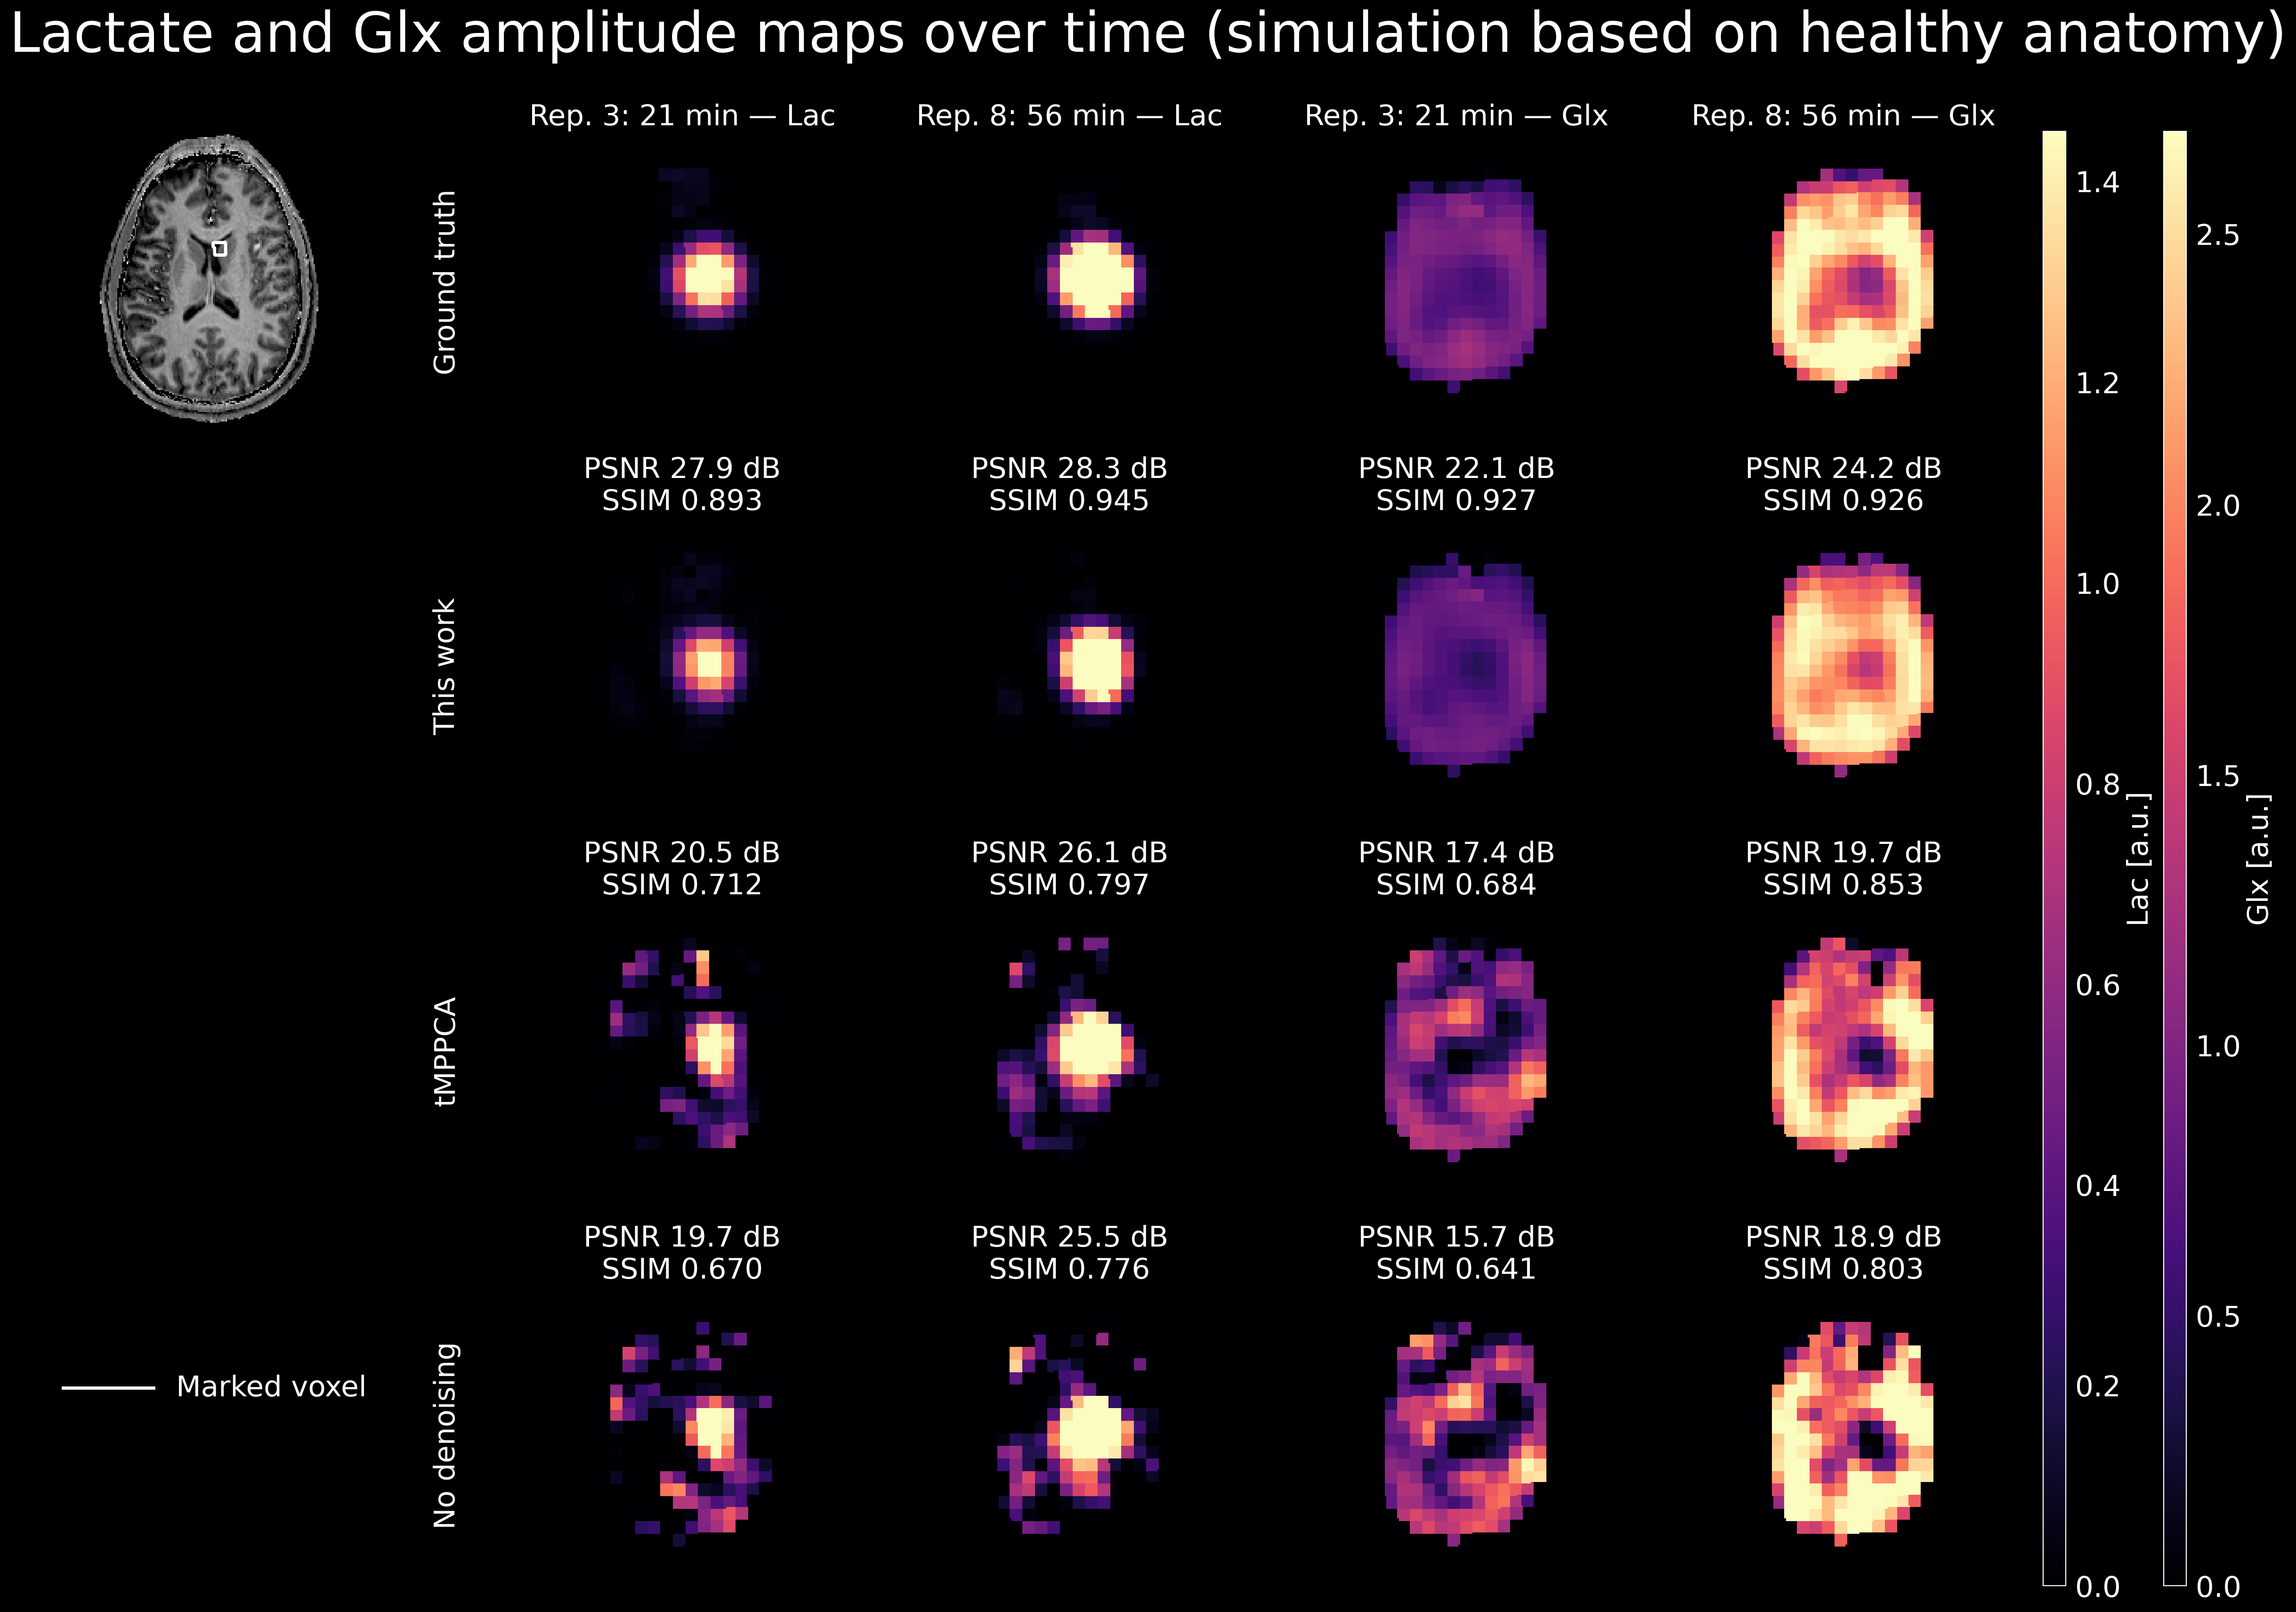

In [ ]:
# pip install nibabel matplotlib numpy scikit-image
import os, numpy as np, nibabel as nib
from nibabel.processing import resample_from_to
from skimage import measure
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

def plot_dmi_timecourse_simulation(
    BASE_LIST, T_INDEX_LIST,
    T1_Z=106, DMI_Z=11,
    T1_WINDOW=(1268, 3619),
    LINEWIDTH=1.8, figsize_scale=1.0,
    method_labels=None, rep_labels=None,
    fontsize=22,  # angepasst
    DMI_BOX_I=None, DMI_BOX_J=None, box_linewidth=2.0, box_color='white',
    align_t1_to_dmi=True,
    LAC_CLIM=None, GLX_CLIM=None, clim_percentiles=(1, 99),
    # Neu:
    BRAIN_MASK_PATH=None,                 # optional: Metriken nur innerhalb Maske
    show_metrics=True, metrics_box=False  # metrics_box=False: Metriken nur im Titel
):
    """
    Simulation:
    - Keine Tumormaske/Legende.
    - Titel: '... (simulation based on healthy anatomy)'
    - PSNR/SSIM zweizeilig dargestellt.
    """
    assert len(BASE_LIST) >= 1
    if method_labels is not None: assert len(method_labels) == len(BASE_LIST)
    if rep_labels is not None:    assert len(rep_labels) == len(T_INDEX_LIST)

    # --- T1 laden ---
    base0 = BASE_LIST[0]
    T1_PATH = os.path.join(base0, "maps", "magnitude.nii")
    t1_img = nib.load(T1_PATH)
    t1 = t1_img.get_fdata()
    t1_aff, t1_shape = t1_img.affine, t1_img.shape

    # optional: Hirnmaske
    brain_mask_t1 = None
    if BRAIN_MASK_PATH is not None and os.path.exists(BRAIN_MASK_PATH):
        brain_mask_t1 = resample_from_to(nib.load(BRAIN_MASK_PATH), (t1_shape, t1_aff), order=0).get_fdata() > 0

    # --- DMI-Z -> T1-Z ---
    def dmi_z_to_t1_z(dmi_img, t1_affine, t1_shape, dmi_z):
        sx, sy, _ = dmi_img.shape
        ijk_dmi = np.array([sx/2.0, sy/2.0, dmi_z, 1.0])
        xyz = dmi_img.affine @ ijk_dmi
        ijk_t1 = np.linalg.inv(t1_affine) @ xyz
        return int(np.clip(np.rint(ijk_t1[2]), 0, t1_shape[2]-1))

    # --- Markierungsbox ---
    def draw_dmi_voxel_box_via_resample(ax, dmi_img, i, j, dmi_z, t1_shape, t1_affine,
                                        t1_slice_index, edgecolor='white', lw=2.0):
        if i is None or j is None: return
        shp = dmi_img.shape
        if not (0 <= i < shp[0] and 0 <= j < shp[1] and 0 <= dmi_z < shp[2]): return
        mask_dmi = np.zeros(shp, dtype=np.uint8); mask_dmi[i, j, dmi_z] = 1
        mask_t1 = resample_from_to(nib.Nifti1Image(mask_dmi, dmi_img.affine),
                                   (t1_shape, t1_aff), order=0).get_fdata() > 0
        for c in measure.find_contours(mask_t1[..., t1_slice_index].T.astype(float), 0.5):
            ax.plot(c[:,1], c[:,0], color=edgecolor, linewidth=lw)

    # --- Loader ---
    def load_metab_on_t1(BASE, T_index, metab):
        p = os.path.join(BASE, "maps", f"{T_index}", "Orig", f"{metab}_amp_map.nii")
        img = nib.load(p)
        return resample_from_to(img, (t1_shape, t1_aff), order=0).get_fdata()

    # --- Metriken ---
    def compute_metrics_2d(gt2d, im2d, mask2d):
        valid = np.isfinite(gt2d) & np.isfinite(im2d)
        if mask2d is not None:
            valid &= mask2d.astype(bool)
        if not np.any(valid):
            return np.nan, np.nan
        gt = gt2d[valid].astype(np.float32)
        im = im2d[valid].astype(np.float32)
        data_range = float(max(gt.max(), im.max()) - min(gt.min(), im.min()))
        if data_range == 0:
            return np.inf, 1.0
        psnr = peak_signal_noise_ratio(gt, im, data_range=data_range)
        im2d_f = im2d.copy(); gt2d_f = gt2d.copy()
        im2d_f[~np.isfinite(im2d_f)] = gt2d_f[~np.isfinite(im2d_f)]
        if mask2d is not None:
            outside = ~mask2d.astype(bool)
            im2d_f[outside] = gt2d_f[outside]
        ssim = structural_similarity(gt2d_f.astype(np.float32),
                                     im2d_f.astype(np.float32),
                                     data_range=data_range)
        return psnr, ssim

    # --- Slice bestimmen ---
    lac0_img_for_z = nib.load(os.path.join(BASE_LIST[0], "maps", f"{T_INDEX_LIST[0]}", "Orig", "Lac_amp_map.nii"))
    T1_Z_MATCH_GLOBAL = dmi_z_to_t1_z(lac0_img_for_z, t1_aff, t1_shape, DMI_Z)

    # --- Auto-CLIMs ---
    def gather_vals(metab):
        vals = []
        for B in BASE_LIST:
            for T in T_INDEX_LIST:
                a = load_metab_on_t1(B, T, metab)
                vals.append(a[np.isfinite(a)])
        vals = np.concatenate(vals)
        p1, p99 = np.percentile(vals, clim_percentiles)
        if p1 == p99: p99 = p1 + 1.0
        return (float(p1), float(p99))

    if LAC_CLIM is None: LAC_CLIM = gather_vals("Lac")
    if GLX_CLIM is None: GLX_CLIM = gather_vals("Glx")

    # === Layout ===
    n_times = len(T_INDEX_LIST)
    nrows = len(BASE_LIST)
    ncols = 1 + 1 + n_times + n_times + 2
    fig_w = figsize_scale * (ncols * 3.0)
    fig_h = figsize_scale * (nrows * 4.0)
    fig = plt.figure(figsize=(fig_w, fig_h), dpi=200, constrained_layout=True)
    fig.patch.set_facecolor('black')
    width_ratios = [1, 0.2] + [1]*n_times + [1]*n_times + [0.06, 0.06]
    gs = GridSpec(nrows, ncols, figure=fig, width_ratios=width_ratios, height_ratios=[1]*nrows)

    cmap_t1  = mpl.cm.get_cmap("gray").copy(); cmap_t1.set_under("black")
    cmap_lac = mpl.cm.get_cmap("magma")
    cmap_glx = mpl.cm.get_cmap("magma")
    norm_lac = mpl.colors.Normalize(vmin=LAC_CLIM[0], vmax=LAC_CLIM[1], clip=True)
    norm_glx = mpl.colors.Normalize(vmin=GLX_CLIM[0], vmax=GLX_CLIM[1], clip=True)
    t1_vmin, t1_vmax = T1_WINDOW
    last_im_lac = None
    last_im_glx = None

    GT_BASE = BASE_LIST[0]
    gt_lac = {T: load_metab_on_t1(GT_BASE, T, "Lac") for T in T_INDEX_LIST}
    gt_glx = {T: load_metab_on_t1(GT_BASE, T, "Glx") for T in T_INDEX_LIST}

    for r, BASE in enumerate(BASE_LIST):
        lac0_img = nib.load(os.path.join(BASE, "maps", f"{T_INDEX_LIST[0]}", "Orig", "Lac_amp_map.nii"))
        T1_Z_MATCH = dmi_z_to_t1_z(lac0_img, t1_aff, t1_shape, DMI_Z)

        # T1
        if r == 0:
            ax_t1 = fig.add_subplot(gs[r, 0]); ax_t1.axis('off')
            zshow = T1_Z_MATCH_GLOBAL if align_t1_to_dmi else T1_Z
            ax_t1.imshow(t1[..., zshow].T, cmap=cmap_t1, vmin=t1_vmin, vmax=t1_vmax,
                         origin='lower', interpolation='nearest')
            if DMI_BOX_I is not None and DMI_BOX_J is not None:
                draw_dmi_voxel_box_via_resample(ax_t1, lac0_img_for_z, DMI_BOX_I, DMI_BOX_J, DMI_Z,
                                                t1_shape, t1_aff, zshow, edgecolor=box_color, lw=box_linewidth)
        else:
            ax_blank = fig.add_subplot(gs[r, 0]); ax_blank.axis('off'); ax_blank.set_facecolor('black')

        # Methodenlabel
        ax_label = fig.add_subplot(gs[r, 1]); ax_label.axis('off'); ax_label.set_facecolor('black')
        label = method_labels[r] if method_labels is not None else os.path.basename(os.path.normpath(BASE))
        ax_label.text(0.5, 0.5, label, color='white', fontsize=fontsize,
                      rotation=90, ha='center', va='center', transform=ax_label.transAxes)

        # --- LAC ---
        for j, T in enumerate(T_INDEX_LIST):
            ax = fig.add_subplot(gs[r, 2 + j]); ax.axis('off')
            ax.imshow(t1[..., T1_Z_MATCH].T, cmap=cmap_t1, vmin=t1_vmin, vmax=t1_vmax,
                      origin='lower', interpolation='nearest')
            lac = load_metab_on_t1(BASE, T, "Lac")
            last_im_lac = ax.imshow(np.ma.masked_invalid(lac[..., T1_Z_MATCH].T),
                                    cmap=cmap_lac, norm=norm_lac, origin='lower', interpolation='nearest')

            if r == 0:
                tlabel = rep_labels[j] if rep_labels is not None else f"T={T}"
                ax.set_title(f"{tlabel} — Lac", color='white', fontsize=fontsize, pad=4)
            elif show_metrics:
                psnr, ssim = compute_metrics_2d(gt_lac[T][..., T1_Z_MATCH], lac[..., T1_Z_MATCH],
                                                brain_mask_t1[..., T1_Z_MATCH] if brain_mask_t1 is not None else None)
                ax.set_title(f"PSNR {psnr:0.1f} dB\nSSIM {ssim:0.3f}",  # ← zweizeilig
                             color='white', fontsize=fontsize, pad=4)

        # --- GLX ---
        glx_offset = 2 + n_times
        for j, T in enumerate(T_INDEX_LIST):
            ax = fig.add_subplot(gs[r, glx_offset + j]); ax.axis('off')
            ax.imshow(t1[..., T1_Z_MATCH].T, cmap=cmap_t1, vmin=t1_vmin, vmax=t1_vmax,
                      origin='lower', interpolation='nearest')
            glx = load_metab_on_t1(BASE, T, "Glx")
            last_im_glx = ax.imshow(np.ma.masked_invalid(glx[..., T1_Z_MATCH].T),
                                    cmap=cmap_glx, norm=norm_glx, origin='lower', interpolation='nearest')

            if r == 0:
                tlabel = rep_labels[j] if rep_labels is not None else f"T={T}"
                ax.set_title(f"{tlabel} — Glx", color='white', fontsize=fontsize, pad=4)
            elif show_metrics:
                psnr, ssim = compute_metrics_2d(gt_glx[T][..., T1_Z_MATCH], glx[..., T1_Z_MATCH],
                                                brain_mask_t1[..., T1_Z_MATCH] if brain_mask_t1 is not None else None)
                ax.set_title(f"PSNR {psnr:0.1f} dB\nSSIM {ssim:0.3f}",  # ← zweizeilig
                             color='white', fontsize=fontsize, pad=4)

    # --- Colorbars ---
    cax_lac = fig.add_subplot(gs[:, ncols-2])
    if last_im_lac is not None:
        cbar_lac = fig.colorbar(last_im_lac, cax=cax_lac)
        cbar_lac.ax.set_facecolor('black'); cbar_lac.outline.set_edgecolor('white')
        plt.setp(cbar_lac.ax.get_yticklabels(), color='white', fontsize=fontsize)
        cbar_lac.set_label("Lac [a.u.]", color='white', fontsize=fontsize)

    cax_glx = fig.add_subplot(gs[:, ncols-1])
    if last_im_glx is not None:
        cbar_glx = fig.colorbar(last_im_glx, cax=cax_glx)
        cbar_glx.ax.set_facecolor('black'); cbar_glx.outline.set_edgecolor('white')
        plt.setp(cbar_glx.ax.get_yticklabels(), color='white', fontsize=fontsize)
        cbar_glx.set_label("Glx [a.u.]", color='white', fontsize=fontsize)

    # --- Titel ---
    fig.suptitle(
        "Lactate and Glx amplitude maps over time (simulation)",
        color='white', fontsize=fontsize + 20, y=1.06
    )

    # --- Marked voxel Legende ---
    legend_x, legend_y, legend_dx = 0.02, 0.175, 0.04
    fig.add_artist(plt.Line2D([legend_x, legend_x + legend_dx],
                              [legend_y - 0.03, legend_y - 0.03],
                              color='white', linewidth=box_linewidth,
                              transform=fig.transFigure, figure=fig))
    fig.text(legend_x + legend_dx + 0.01, legend_y - 0.03, "Marked voxel",
             color='white', va='center', fontsize=fontsize, transform=fig.transFigure)

    plt.show()
    fig.savefig("output_simulation.pdf", bbox_inches='tight', facecolor=fig.get_facecolor())

# Beispielaufruf:
plot_dmi_timecourse_simulation(
    BASE_LIST=[
        "MetabMaps/Lesion_Double_GT",
        "MetabMaps/Lesion_Double_deep_tMPPCA_5D",
        "MetabMaps/Lesion_Double_tMPPCA_5D",
        "MetabMaps/Lesion_Double_Noisy"
    ],
    T_INDEX_LIST=[3,8],
    method_labels=["Ground truth", "This work", "tMPPCA", "No denoising"],
    rep_labels=["Rep. 3: 21 min", "Rep. 8: 56 min"],
    DMI_BOX_I=11, DMI_BOX_J=13, DMI_Z=11,
    align_t1_to_dmi=True,
    box_linewidth=2.5, box_color='white'
)


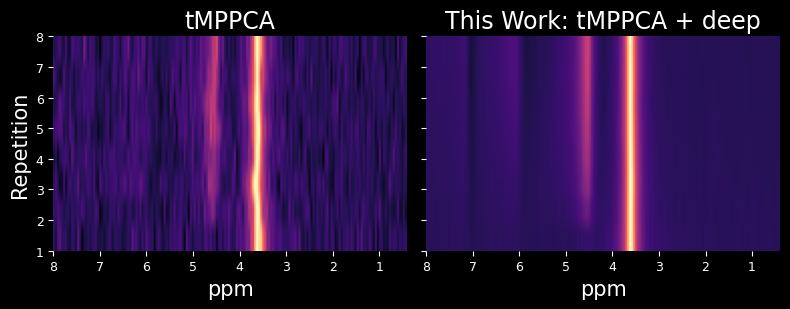

In [3]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from typing import Tuple, List

def load_example_spectrum(base_dir: str, rep: int, xyz: tuple[int, int, int],
                          filename: str = "SpecMap_LCMInput.nii.gz") -> np.ndarray:
    spec_path = os.path.join(base_dir, "maps", str(rep), "SpecMap", filename)
    if not os.path.isfile(spec_path):
        raise FileNotFoundError(f"Spektrum nicht gefunden: {spec_path}")
    img = nib.load(spec_path)
    data = img.get_fdata()
    if data.ndim != 4:
        raise ValueError(f"Erwarte 4D (X,Y,Z,S), gefunden: {data.shape}")
    x, y, z = xyz
    return np.asarray(data[x, y, z, :], dtype=np.float64).ravel()

def load_spectra_matrix(method_dir: str, xyz: Tuple[int,int,int], reps: List[int],
                        filename: str = "SpecMap_LCMInput.nii.gz", normalize_per_rep: bool = True) -> np.ndarray:
    spectra, max_len = [], 0
    temp = []
    for rep in reps:
        try:
            s = load_example_spectrum(method_dir, rep, xyz, filename)
            if normalize_per_rep:
                s = s / (np.nanmax(np.abs(s)) or 1.0)
            temp.append(s)
            max_len = max(max_len, s.size)
        except FileNotFoundError:
            temp.append(None)
    for s in temp:
        if s is None:
            spectra.append(np.full(max_len, np.nan))
        else:
            pad = max_len - s.size
            spectra.append(np.pad(s, (0,pad), constant_values=np.nan))
    return np.vstack(spectra)

def plot_two_methods_heatmaps(
    base_dir_root: str,
    method_left: str,
    method_right: str,
    reps: List[int],
    xyz: Tuple[int,int,int],
    ppm: np.ndarray,
    spec_filename: str = "SpecMap_LCMInput.nii.gz",
    share_vscale: bool = True,
    title_left: str | None = None,
    title_right: str | None = None,
    save_pdf: str | None = None,
):
    # Laden
    M1 = load_spectra_matrix(os.path.join(base_dir_root, method_left),  xyz, reps, spec_filename)
    M2 = load_spectra_matrix(os.path.join(base_dir_root, method_right), xyz, reps, spec_filename)

    def match_ppm(ppm, S):  # PPM an Spektrallänge anpassen
        return ppm if ppm.size == S else np.linspace(ppm.min(), ppm.max(), S)

    ppm1 = match_ppm(ppm, M1.shape[1])
    ppm2 = match_ppm(ppm, M2.shape[1])

    # Farbskala
    if share_vscale:
        vmin = np.nanmin([M1, M2])
        vmax = np.nanmax([M1, M2])
    else:
        vmin = vmax = None

    # --- Plot ---
    fig, axes = plt.subplots(1, 2, figsize=(8, 3.2), sharey=True)
    fig.patch.set_facecolor("black")

    for ax, M, p, ttl in [
        (axes[0], M1, ppm1, title_left or method_left),
        (axes[1], M2, ppm2, title_right or method_right),
    ]:
        ax.set_facecolor("black")
        im = ax.imshow(
            M,
            aspect="auto",
            origin="lower",
            extent=[p.min(), p.max(), 1, len(reps)],
            cmap="magma",
            vmin=vmin,
            vmax=vmax,
        )
        ax.set_title(ttl, fontsize=17, color="white")
        ax.set_xlabel("ppm", fontsize=15, color="white")
        if ax is axes[0]:
            ax.set_ylabel("Repetition", fontsize=15, color="white")
        ax.invert_xaxis()
        ax.tick_params(colors="white", labelsize=9)
        for spine in ax.spines.values():
            spine.set_visible(False)

    plt.tight_layout()
    if save_pdf:
        fig.savefig(save_pdf, bbox_inches="tight", facecolor="black")
    plt.show()

# ===== Beispielaufruf =====
base_dir_root = "MetabMaps"
method_left  = "Lesion_Double_tMPPCA_5D"
method_right = "Lesion_Double_deep_tMPPCA_5D"
reps = list(range(1, 9))
xyz  = (11, 13, 11)
ppm  = np.linspace(8, 0.4, 176)

plot_two_methods_heatmaps(
    base_dir_root=base_dir_root,
    method_left=method_left,
    method_right=method_right,
    reps=reps,
    xyz=xyz,
    ppm=ppm,
    share_vscale=True,
    title_left="tMPPCA",
    title_right="This Work: tMPPCA + deep",
    save_pdf="spectra_heatmaps_dark.pdf",
)


